# R kernel

In [1]:
suppressMessages({
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggpubr)
library(cowplot)
library(gridExtra)
library(rstatix)
library(reshape2)
library(ggnewscale)
library(RColorBrewer)
})

In [4]:
mytheme = function(){
theme_bw() +
theme(axis.text.x=element_text(size=6,color='black'),
    axis.text.y=element_text(size=6,color="black"),
    axis.title.y=element_text(size=6,color="black"),
    axis.title.x=element_text(size=6,color="black"),
    #axis.ticks.x=element_blank(),
    axis.ticks.length=unit(.02, "in"),
    axis.line = element_line(color = "black", linewidth = 0.25),
    axis.ticks = element_line(color = "black", linewidth = 0.25),
    strip.text.x = element_text(size = 6,margin = margin(0.1,0,0.1,0, "cm")),
    strip.text.y = element_text(size = 6,margin = margin(0,0.1,0,0.1, "cm")),
    strip.background=element_rect(linewidth=0.25),
    legend.text=element_text(size=6,color="black"),
    legend.title=element_text(size=6,color="black"),
    legend.key.width=unit(0.2,'cm'),
    legend.key.height=unit(0.2,'cm'),
    legend.box.margin=margin(0,0,0,2),
    legend.box.spacing = unit(0, "pt"),
    panel.spacing = unit(0.1, "cm"),
    plot.title = element_text(size=5),
    #panel.border = element_rect(size=0.25,color="black"),
    panel.grid = element_blank()
)
}

## Fig.S4B

In [2]:
KC_celltype_order = c("Granular KC","Spinous KC-1","Spinous KC-2","Spinous KC-3","Spinous KC-4","Basal KC",
                      "IRS","ORS","OB", "HF-SG","Channel KC","Stress KC","Cycling KC")
group_order = c('HC','DLE','SLE')
group_color = c('HC' = '#d05204', 'DLE' = '#019167', 'SLE' = '#0166aa')

In [3]:
Epi_KC_rate = read.csv("../Figure2/Epi_KC_rate_depth.csv",head=T, row.names=1)
Depth_bin_order = c("(-0.001, 0.1]", "(0.1, 0.2]", "(0.2, 0.3]", "(0.3, 0.4]", "(0.4, 0.5]", "(0.5, 0.6]", "(0.6, 0.7]", "(0.7, 0.8]", "(0.8, 0.9]", "(0.9, 1.0]")
Epi_KC_rate$Depth_bin = factor(Epi_KC_rate$Depth_bin, levels=rev(Depth_bin_order))
Epi_KC_rate$subtype = factor(Epi_KC_rate$subtype, levels=KC_celltype_order)

In [7]:
KC_other = c('Spinous KC-1','Spinous KC-2','Spinous KC-3','Spinous KC-4','Basal KC','IRS','HF-SG','Channel KC' )

In [13]:
plots = list()
for (i in 1:length(KC_other))
{
    stat.test.lst <- list()
    com_group.lst <- list()
    
    com_group.lst[[1]] <- c('HC', 'DLE')
    com_group.lst[[2]] <- c('HC', 'SLE')

    Epi_KC_subtype = subset(Epi_KC_rate, subtype == KC_other[i])
    
    if (KC_other[i] != 'IRS')
    {
        for (com_group in com_group.lst){
            prefix = paste(com_group, collapse = '_vs_')
    
            Epi_KC_test <- Epi_KC_subtype[Epi_KC_subtype$group %in% com_group,]
            stat.test.lst[[prefix]] <- Epi_KC_test %>% group_by(Depth_bin) %>% wilcox_test(proportion ~ group, p.adjust.method = "none") %>% add_xy_position(x='Depth_bin')
            stat.test.lst[[prefix]]$p.signif = ifelse(stat.test.lst[[prefix]]$p <0.0001, '****',
                                        ifelse(stat.test.lst[[prefix]]$p <0.001 & stat.test.lst[[prefix]]$p > 0.0001, '***',
                                        ifelse(stat.test.lst[[prefix]]$p <0.01 & stat.test.lst[[prefix]]$p > 0.001, '**', 
                                        ifelse(stat.test.lst[[prefix]]$p <0.05 & stat.test.lst[[prefix]]$p > 0.01, '*','ns'
                                        ))))
        }
        
        stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =1.1)
        stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =1.3)
        if (KC_other[i] == 'Spinous KC-1')
        {
            stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =1.5)
            stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =1.7)
        }
    
        if (KC_other[i] == 'Spinous KC-2')
        {
            stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =3.5)
            stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =4)
        }

        if (KC_other[i] == 'Spinous KC-3')
        {
            stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =14.5)
            stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =16)
        }

        if (KC_other[i] == 'Spinous KC-4')
        {
            stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =7)
            stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =7.5)
        }

        if (KC_other[i] == 'Basal KC')
        {
            stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =6.5)
            stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =7)
        }
    }
    
    plots[[i]] <- ggline(Epi_KC_subtype, x="Depth_bin", y="proportion", add=c("mean_se"),  error.plot = "errorbar", 
                add.params = list(size = 1, width = 0.3),color = "group", palette = group_color, shape=20, stroke=NA, size=0.25,
                point.size = 0.1, nrow=1) +
    coord_flip() +
    labs(title=KC_other[i]) +
    mytheme() +
        theme(#axis.text.x=element_text(size=5,color="black",angle=90,hjust=1,vjust=0.5),
        axis.text.y=element_text(size=6,color="black"),
        axis.title=element_text(size=6,color="black"),
        plot.title=element_text(size=6,color="black"),
        strip.background=element_rect(linewidth=0.25, color='black', fill="white"),
        panel.spacing = unit(0.15, "cm"),
        legend.position = "none"
    )

    if (KC_other[i] != 'IRS')
    {
        plots[[i]] <- plots[[i]] +  
        stat_pvalue_manual(stat.test.lst[['HC_vs_DLE']], label = "p.signif", linetype  = "blank", hide.ns = TRUE, hjust=0.5, vjust = 1, color = '#019167',label.size=2.5) + 
        stat_pvalue_manual(stat.test.lst[['HC_vs_SLE']], label = "p.signif", linetype  = "blank", hide.ns = TRUE, hjust=0.5, vjust = 1, color = '#0166aa',label.size=2.5)
    }  
}

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


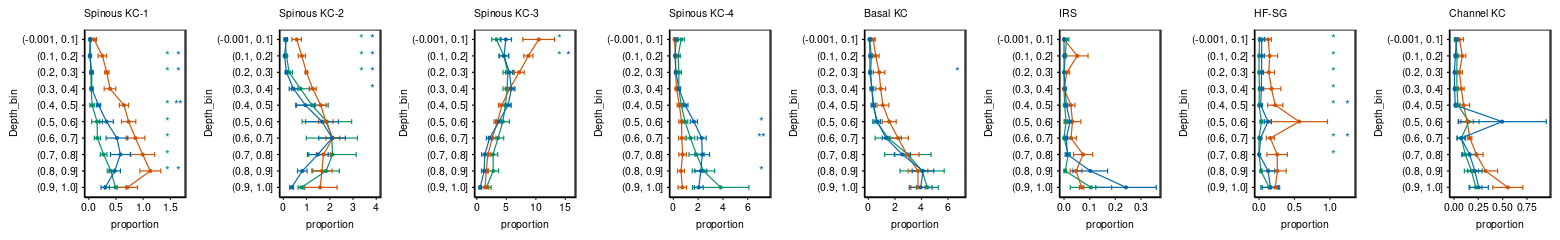

In [15]:
options(repr.plot.width =13,repr.plot.height = 2)
do.call(grid.arrange,c(plots,ncol=8))

# Python kernel

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.backends.backend_pdf as pdf_backend
import warnings
warnings.filterwarnings('ignore')
import importlib

import utils_20250718
importlib.reload(utils_20250718)
from utils_20250718 import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Fig.S4A

In [2]:
ST_adata = sc.read_h5ad('/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Cellbin_h5ad_raw/All_samples_Cellbin_filter_gene200_add_anno_dist.h5ad')

In [4]:
KC_celltype_colors = {
    "Granular KC" : "#0089A3",
    "Spinous KC-1" : "#FF0000FF",
    "Spinous KC-2" : "#FF7F0EFF",
    "Spinous KC-3" : "#CCFF00FF",
    "Spinous KC-4" : "#EEC3FF",
    "Basal KC" : "#2CA02CFF",
    "IRS" : "#99CCFFFF",
    "ORS" : "#CC33FFFF",
    "OB" : "#FFCC00FF",
    "HF-SG" : "#FFFF00FF",
    "Channel KC" : "#A77500",
    "Stress KC" : "#00FFFFFF",
    "Cycling KC" : "#FF00CCFF"
}

In [3]:
samples = ["HC1",'HC2','HC3','HC4',"DLE1","DLE2","DLE3",'DLE4',"DLE5","SLE1","SLE3","SLE4","SLE5","SLE6"]

[21:41:58] ❕  ssat is not registered, register now                                           ]8;id=529867;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=173251;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=223383;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=512664;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=104139;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=802860;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=625511;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=103232;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=50997;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=134942;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=229763;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=174985;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:41:59] ❕  ssat is not registered, register now                                           ]8;id=500830;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=143756;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=654159;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=854460;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=102599;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=952638;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=650788;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=633918;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=917017;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=830096;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[21:42:00] 📃  add palette for `subtype` to adata.uns                                        ]8;id=180529;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=255406;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=906581;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=512767;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=498570;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=696481;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=49887;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=391075;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[21:42:01] 📃  add palette for `subtype` to adata.uns                                        ]8;id=768209;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=485005;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:42:02] ❕  ssat is not registered, register now                                           ]8;id=729114;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=677601;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=492770;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=31150;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=206191;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=465603;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[21:42:03] 📃  add palette for `subtype` to adata.uns                                        ]8;id=258960;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=239388;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=914310;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=700653;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=256126;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=38603;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=864599;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=69481;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[21:42:04] 📃  add palette for `subtype` to adata.uns                                        ]8;id=858052;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=989193;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=297984;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=759069;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=921534;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=502495;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:42:05] ❕  ssat is not registered, register now                                           ]8;id=109450;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=765756;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `subtype` to adata.uns                                        ]8;id=728709;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=136528;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

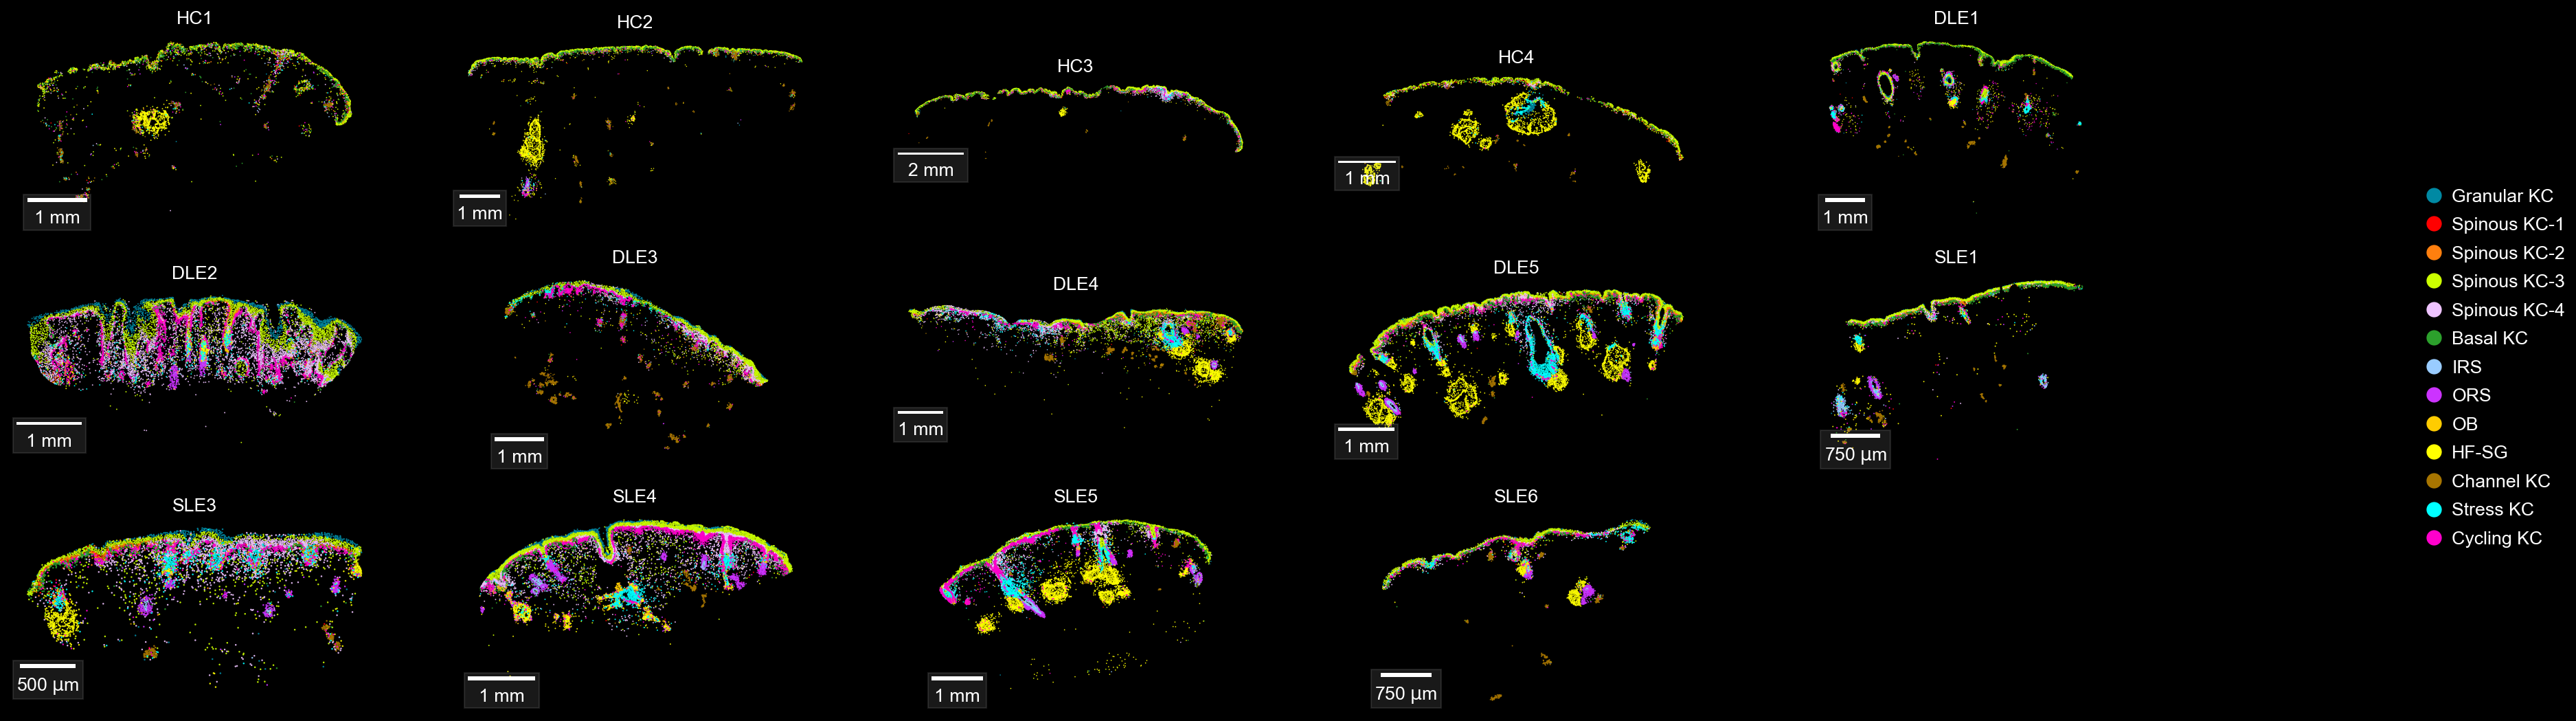

In [10]:
with mpl.style.context("dark_background"): 
    fig, axs =plt.subplots(figsize=(25, 8), ncols=5,nrows=3) 
    axs = axs.flatten()
    for i in range(0,len(samples)):
        sample_adata = ST_adata[ST_adata.obs['sample'] == samples[i]]
              
        ax = dimplot(sample_adata,background=False,groupby="subtype", reduction="spatial", order=KC_celltype_colors.keys(), dot_size=20,legend=False,ax=axs[i], palette=KC_celltype_colors) #
        ax.set_title(f'{samples[i]}', fontsize=12)
        draw_scalebar(ax=ax, color='white',location='lower left')
    plot_legend(fig=fig)
    for ax in axs:
        ax.axis('off')